In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from collections import Counter
import gc
from datetime import datetime
import pickle
import re
import distance
import spacy
import nltk
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz

import optuna
from xgboost import XGBClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import log_loss, accuracy_score, precision_recall_curve, auc,\
                                                    roc_curve, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm


In [2]:
gc.collect()

49

In [2]:
!pip install distance -q

In [3]:
def save_obj(filepath, obj):
    with open(filepath,"wb") as file:
        pickle.dump(file=file,obj=obj)
        
def load_obj(filepath):
    with open(filepath,"rb") as file:
        obj = pickle.load(file)
    return obj

In [4]:
df = pd.read_csv("/kaggle/input/actual-train/train.csv")

In [5]:
class FeatureEngineering(BaseEstimator, TransformerMixin):

    def __init__(self):
        nltk.download('stopwords')
        self.SAFE_DIV = 0.0001 # to get result in 4 decimal points
        self.STOP_WORDS = stopwords.words('english')
        self.start = datetime.now()

    def fit(self,X,y=None):
        return self

    def transform(self, X,y=None):
        print(f"{'*'*15}Transformation Started{'*'*15}")
        
        print(f"-----> Data Cleaning in process{'.'*10}")
        X = self.data_cleaning(X)
        
        # preprocessing each question
        print(f"-----> Questions Text Cleaning Started{'.'*10}")
        X['question1'] = X["question1"].fillna("").apply(self.preprocess)
        X['question2'] = X["question2"].fillna("").apply(self.preprocess)
        
        df = self.common_features(self.extract_features(X))
        
        
        df = df.drop(columns=["qid1","qid2"])
        
        print(f"-----> Finalizing DataFrame{'.'*10}")
        return df
        #max_min = load_model("/config/workspace/min_max.pkl")
        #dist_df["euclidean_dist"] = max_min.transform(dist_df[['euclidean_dist']])
        
    
    def data_cleaning(self,data):
        data.fillna('', inplace=True)
        indexes=[]
        pattern = '''[!"#%&'(\*)\+,\./:;<=>\?@\[\]\^_`\{\|\}~]'''
        for row in data.iterrows():
            r_id = row[1].id
            q1 = row[1].question1.lower()
            q2 = row[1].question2.lower()
            
            if len(q1) < 10:
                indexes.append(r_id)
            q1 = re.sub(pattern, '',q1)
            
            if q1 in ['deleted','removed']:
                indexes.append(r_id)
                
            if len(q2) < 10:
                indexes.append(r_id)
            q2 = re.sub(pattern, '',q2)
            
            if q2 in ['deleted','removed']:
                indexes.append(r_id)
                
        data.drop(index=indexes, inplace=True)
        return data

    def normalized_word_Common(self,row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)


    def normalized_word_Total(self, row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0*(len(w1) + len(w2))


    def normalized_word_share(self, row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

    def common_features(self, data:pd.DataFrame) -> pd.DataFrame:
        print(f"-----> Finding Common Features{'.'*10}")
        data['q1len'] = data['question1'].str.len()
        data['q2len'] = data['question2'].str.len()
        data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
        data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))
        data['word_Common'] = data.apply(self.normalized_word_Common, axis=1)
        data['word_Total'] = data.apply(self.normalized_word_Total, axis=1)
        data['word_share'] = data.apply(self.normalized_word_share, axis=1)
        return data

    def preprocess(self, x):
        x = str(x).lower()
        x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                            .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                            .replace("n't", " not").replace("what's", "what is").replace("it's", "it is").replace("didn't","did not")\
                            .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                            .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                            .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                            .replace("€", " euro ").replace("'ll", " will")
        x = re.sub(r"([0-9]+)000000", r"\1m", x)
        x = re.sub(r"([0-9]+)000", r"\1k", x)

        porter = PorterStemmer()
        pattern1 = re.compile('\W')

        if type(x) == type(''):
            x = re.sub(pattern1,' ',x)

        if type(x) == type(''):
            x = porter.stem(x)
            example1 = BeautifulSoup(x)
            x = example1.get_text()
            
        ## removing remaining punctuations
        pattern2 = '''[!"#%&'(\*)\+,\./:;<=>\?@\[\]\^_`\{\|\}~]'''
        x= re.sub(pattern2, '',x).strip()
        return x

    def get_token_features(self, q1, q2):
        token_features = [0.0]*10

        # Converting questions into tokens
        q1_tokens = q1.split()
        q2_tokens = q2.split()

        if len(q1_tokens)== 0 or len(q2_tokens)==0:
            return token_features

        # Getting non-stopwords in Questions
        q1_words = set([word for word in q1_tokens if word not in self.STOP_WORDS])
        q2_words = set([word for word in q2_tokens if word not in self.STOP_WORDS])

        # Getting stopwords in Questions
        q1_stops = set([word for word in q1_tokens if word in self.STOP_WORDS])
        q2_stops = set([word for word in q2_tokens if word in self.STOP_WORDS])

        # Getting the common non-stopwords from questions pair
        common_word_count = len(set(q1_words).intersection(set(q2_words)))

        # Getting the common stopwords from questions pair
        common_stop_count = len(set(q1_stops).intersection(set(q2_stops)))

        # Getting the common non-stopwords from questions pair
        common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

        token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + self.SAFE_DIV)
        token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + self.SAFE_DIV)
        token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + self.SAFE_DIV)
        token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + self.SAFE_DIV)
        token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + self.SAFE_DIV)
        token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + self.SAFE_DIV)

        # Last word of both questions is same or not
        token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

        # First word of both questions is same or not
        token_features[7] = int(q1_tokens[0] == q2_tokens[0])

        token_features[8] = abs(len(q1_tokens) - len(q2_tokens))

        # Average token length of both Questions
        token_features[9] = (len(q1_tokens) + len(q2_tokens))/2

        return token_features

    def get_longest_substr_ratio(self,a,b):
        strs = list(distance.lcsubstrings(a,b))
        if len(strs) == 0:
            return 0
        else:
            return len(strs[0]) / (min(len(a), len(b))+1)

    def extract_features(self,df):
        print(f"-----> Finding Token Features{'.'*10}")

        # Merging features with dataset
        token_features = df.apply(lambda x: self.get_token_features(x['question1'], x['question2']), axis=1)

        df["cwc_min"]       = list(map(lambda x:x[0], token_features))
        df["cwc_max"]       = list(map(lambda x:x[1], token_features))
        df["csc_min"]       = list(map(lambda x:x[2], token_features))
        df["csc_max"]       = list(map(lambda x:x[3], token_features))
        df["ctc_min"]       = list(map(lambda x:x[4], token_features))
        df["ctc_max"]       = list(map(lambda x:x[5], token_features))
        df["last_word_eq"]  = list(map(lambda x:x[6], token_features))
        df["first_word_eq"] = list(map(lambda x:x[7], token_features))
        df["abs_len_diff"]  = list(map(lambda x:x[8], token_features))
        df["mean_len"]      = list(map(lambda x:x[9], token_features))

        ## Computing fuzzy features
        print(f"-----> Finding Fuzzy Features{'.'*10}")

        df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']),axis=1)
        df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']),axis=1)
        df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(x['question1'], x['question2']),axis=1)
        df['q_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']),axis=1)
        df['W_ratio'] = df.apply(lambda x: fuzz.WRatio(x['question1'], x['question2']),axis=1)
        df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']),axis=1)
        df['longest_substr_ratio'] = df.apply(lambda x: self.get_longest_substr_ratio(x['question1'], x['question2']),axis=1)
        return df

    def vec_generator(self, df, feature, word2tfidf, nlp):
        print(f"-----> Generating sentence vectors for {feature} {'.'*10}")
        vecs1 = []
        for qu1 in tqdm(list(df[feature])):
            doc1 = nlp(qu1)
            mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)]) 

            for word1 in doc1:
                vec1 = word1.vector

                try:
                    idf = word2tfidf[str(word1)]
                except:
                    idf = 0
                mean_vec1 += vec1*idf

            mean_vec1 = mean_vec1.mean(axis=0)
            vecs1.append(mean_vec1)
        return list(vecs1)
    
    def similarity_distance_calculate(self,q1,q2):
        cosine_sim=[]
        euclidean_dist=[]
        for idx in tqdm(range(len(q1))):
            cosine_sim.append(cosine_similarity([q1[idx]],[q2[idx]]))
            euclidean_dist.append(euclidean_distances([q1[idx]],[q2[idx]]))

        dist_df = pd.DataFrame({"cosine_sim":np.array(cosine_sim).flatten(),
                                "euclidean_dist":np.array(euclidean_dist).flatten()})
        return dist_df
    
    def __del__(self):
        print(f"{'*'*10} Feature Transformation completed Successfully {'*'*10}")
        print(f"{'>'*5} Time talken for Execution : {datetime.now()-self.start} {'<'*5}")
    

In [6]:
feat_eng= FeatureEngineering()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
save_obj("feat_eng.pickle", feat_eng)

In [8]:
transformed_df = feat_eng.fit_transform(df)

***************Transformation Started***************
-----> Data Cleaning in process..........
-----> Questions Text Cleaning Started..........
-----> Finding Token Features..........
-----> Finding Fuzzy Features..........
-----> Finding Common Features..........
-----> Finalizing DataFrame..........


In [9]:
def Tfidf_vectorizer(df):
    ## Merging texts of questions
    questions = list(df['question1'] + df['question2'])

    ## Finding tfidf of questions
    tfidf = TfidfVectorizer(lowercase=False)
    tfidf.fit_transform(questions)

    # dict key:word and value:tf-idf score
    word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
    return word2tfidf

In [10]:
gc.collect()

262

In [ ]:
!python -m spacy download en_core_web_lg

In [12]:
nlp = spacy.load("en_core_web_lg")
word2tfidf = Tfidf_vectorizer(transformed_df)

In [13]:
gc.collect()

139

In [ ]:
transformed_df["q1_feats_m"] = feat_eng.vec_generator(transformed_df, "question1",word2tfidf, nlp)
transformed_df["q2_feats_m"] = feat_eng.vec_generator(transformed_df, "question2",word2tfidf,nlp)

-----> Generating sentence vectors for question1 ..........


 44%|████▍     | 177143/404184 [23:57<32:03, 118.06it/s] 

In [15]:
transformed_df["q2_feats_m"] = feat_eng.vec_generator(transformed_df, "question2",word2tfidf,nlp)

-----> Generating sentence vectors for question2 ..........


100%|██████████| 404184/404184 [58:42<00:00, 114.73it/s] 


In [16]:
print(f"-----> Processing Vectors generated{'.'*10}")
q1 = pd.DataFrame(transformed_df['q1_feats_m'].values.tolist(), index = transformed_df.index)
q2 = pd.DataFrame(transformed_df['q2_feats_m'].values.tolist(), index = transformed_df.index)

-----> Processing Vectors generated..........


In [17]:
print(f"-----> Calculating Similarity and Distance scores{'.'*10}")
dist_df=feat_eng.similarity_distance_calculate(transformed_df["q1_feats_m"].values.tolist(),
                                           transformed_df["q2_feats_m"].values.tolist())

-----> Calculating Similarity and Distance scores..........


100%|██████████| 404184/404184 [02:41<00:00, 2496.82it/s]


In [18]:
transformed_df.drop(['question1','question2','q1_feats_m','q2_feats_m'],axis=1, inplace=True)
q1['id']=transformed_df['id']
q2['id']=transformed_df['id']
dist_df['id']=transformed_df['id']
transformed_df = transformed_df.merge(dist_df, on='id',how='left')
df2  = q1.merge(q2, on='id',how='left')
final_df  = transformed_df.merge(df2, on='id',how='left')

In [19]:
final_df.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0,1,...,80.469136,-101.418015,-95.846383,85.933494,18.879512,-19.346158,-13.107483,-115.882590,-115.647598,78.194888
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0,1,...,58.186935,49.383394,97.052887,36.787597,-107.018638,39.131260,-85.963220,37.030713,-107.075535,74.811190
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0,1,...,82.083717,-29.188682,44.786664,77.375877,-52.112172,107.327137,126.036201,-192.853296,-65.878762,165.468762
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,-63.469887,67.147748,-224.327697,77.558459,171.015095,94.830930,362.882015,-74.057362,209.312132,30.363509
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0,1,...,94.967663,-52.874635,107.827701,-51.582111,-146.524910,-51.698985,16.533946,-51.025454,-26.802626,0.395553


In [20]:
final_df.to_parquet("transformed_df.parquet")

In [3]:
final_df = pd.read_parquet("/kaggle/input/transformed-df/transformed_df.parquet")

In [4]:
y_true = final_df['is_duplicate']
final_df.drop(['id','is_duplicate'], axis=1, inplace=True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(final_df,y_true, stratify=y_true, test_size=0.20)

In [54]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train['euclidean_dist'] = sc.fit_transform(X_train[['euclidean_dist']])

In [55]:
X_test['euclidean_dist'] = sc.transform(X_test[['euclidean_dist']])

In [19]:
del final_df
gc.collect()

261

In [31]:
# For Ploting confusion matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = ((C.T)/(C.sum(axis=1))).T  # divide each element of confusion matrix with sum of elements in that column
    B = C/C.sum(axis=0) # divide each element of confusion matrix with sum of elements in that row
    
    plt.figure(figsize=(20,4))
    labels = [1,2]
    cmap = sns.light_palette("pink")
    
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 15})
    plt.xlabel("Predicted Class",fontsize=15)
    plt.ylabel("Original Class",fontsize=15)
    plt.title("Confusion Matrix",fontsize=20)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 15})
    plt.xlabel('Predicted Class',fontsize=15)
    plt.ylabel('Original Class',fontsize=15)
    plt.title("Precision matrix",fontsize=20)
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 15})
    plt.xlabel('Predicted Class',fontsize=15)
    plt.ylabel('Original Class',fontsize=15)
    plt.title("Recall matrix",fontsize=20)
    
    plt.show()

In [32]:
def prediction_evaluation(model, model_name, X_train, y_train, X_test, y_test):
    print(f"\n{'-'*15} {model_name} Performance {'-'*15}")
    predict_y  = model.predict_proba(X_train)
    log_loss_error = log_loss(y_train, predict_y, labels=[0,1], eps=1e-15)
    print(f"{model_name} --> Train --> Log-Loss = {round(log_loss_error,4)}")
    train_roc= roc_auc_score(y_train, predict_y[:,1], labels=[0,1])
    print(f"{model_name} --> Train --> ROC-AUC Score = {round(train_roc,4)}")

    predict_y  = model.predict_proba(X_test)
    log_loss_error = log_loss(y_test, predict_y, labels=[0,1], eps=1e-15)
    print(f"{model_name} --> Test --> Log-Loss = {round(log_loss_error,4)}")
    test_roc= roc_auc_score(y_test, predict_y[:,1], labels=[0,1])
    print(f"{model_name} --> Test --> ROC-AUC Score = {round(test_roc,4)}")

    plot_confusion_matrix(y_test, np.argmax(predict_y,axis=1))

In [56]:
gc.collect()

30205

In [ ]:
start = datetime.now()
logistic = LogisticRegression()
logistic.fit(X_train,y_train)
print(f"Training Time = {datetime.now()-start}")

print("Performance Calculation in progress.........")
prediction_evaluation(logistic,"Logistic",X_train, y_train, X_test, y_test)

In [3]:
start = datetime.now()
sig_clf_log = CalibratedClassifierCV(logistic, method="sigmoid")
sig_clf_log.fit(X_train, y_train)
print(f"Training Time = {datetime.now()-start}")

print("Performance Calculation in progress..........")
prediction_evaluation(sig_clf_log,"Logistic Sig Calibrated",X_train, y_train, X_test, y_test)

NameError: name 'logistic' is not defined

In [57]:
def objective(trial,data = X_train, target = y_train):
    param = {
        #'tree_method' : 'gpu_hist',
        'reg_lambda' : trial.suggest_loguniform('lambda', 1e-4, 10.0),
        'reg_alpha' :  trial.suggest_loguniform('alpha', 1e-4, 10.0),
        'booster' : trial.suggest_categorical('booster',['gbtree','dart']),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
        'subsample' : trial.suggest_categorical('subsample', [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
        'learning_rate' : trial.suggest_categorical('learning_rate',[.00001,.0003,.008,.02,.01,1,10,20]),
        'n_estimators' : trial.suggest_categorical('n_estimator',[200,300,400,500]),
        'max_depth' : trial.suggest_categorical('max_depth', [3,4,5,6,7,8,9,10,11,12]),
        'min_child_weight' : trial.suggest_int('min_child_weight',1,200),
    }
    xgb_reg_model = XGBClassifier(objective="binary:logistic",
                              tree_method = 'gpu_hist',
                              early_stopping_rounds=20,
                              verbosity = 2, 
                              eval_metric='logloss', 
                              random_state=30,
                              **param)
    xgb_reg_model.fit(X_train,y_train, eval_set = [(X_test,y_test)], verbose = 2)
    pred_xgb = xgb_reg_model.predict_proba(X_test)
    logloss = log_loss(y_test, pred_xgb, labels=[0,1], eps=1e-15)
    return logloss

In [58]:
start = datetime.now()
find_param = optuna.create_study(study_name="xgboost_exp_5",direction='minimize')
find_param.optimize(objective, n_trials = 10)
params4 = find_param.best_params
print(params4)
print("Training Time = {}".format(datetime.now()-start))

[I 2023-03-09 19:45:24,309] A new study created in memory with name: xgboost_exp_5


[19:45:37] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:2.87744
[19:45:38] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:45:38] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:13.60501
[19:45:38] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:45:38] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:13.60501
[19:45:38] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:45:38] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:13.60501
[19:45:38] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:45:38] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:13.60501
[19:45:39] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:45:39] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:13.60501
[19:45:39] INFO: ../src/gbm/gbtree.cc:909: drop 

[I 2023-03-09 19:45:40,504] Trial 0 finished with value: 2.8343950003199074 and parameters: {'lambda': 8.00563980953578, 'alpha': 0.04041245381289044, 'booster': 'dart', 'colsample_bytree': 0.3, 'subsample': 0.2, 'learning_rate': 20, 'n_estimator': 300, 'max_depth': 7, 'min_child_weight': 115}. Best is trial 0 with value: 2.8343950003199074.


[0]	validation_0-logloss:0.68742
[2]	validation_0-logloss:0.67594
[4]	validation_0-logloss:0.66539
[6]	validation_0-logloss:0.65647
[8]	validation_0-logloss:0.64716
[10]	validation_0-logloss:0.63880
[12]	validation_0-logloss:0.62992
[14]	validation_0-logloss:0.62187
[16]	validation_0-logloss:0.61436
[18]	validation_0-logloss:0.60731
[20]	validation_0-logloss:0.60080
[22]	validation_0-logloss:0.59421
[24]	validation_0-logloss:0.58861
[26]	validation_0-logloss:0.58419
[28]	validation_0-logloss:0.57872
[30]	validation_0-logloss:0.57335
[32]	validation_0-logloss:0.56929
[34]	validation_0-logloss:0.56468
[36]	validation_0-logloss:0.56009
[38]	validation_0-logloss:0.55634
[40]	validation_0-logloss:0.55217
[42]	validation_0-logloss:0.54792
[44]	validation_0-logloss:0.54394
[46]	validation_0-logloss:0.53993
[48]	validation_0-logloss:0.53664
[50]	validation_0-logloss:0.53311
[52]	validation_0-logloss:0.52992
[54]	validation_0-logloss:0.52703
[56]	validation_0-logloss:0.52427
[58]	validation_0-l

[I 2023-03-09 19:46:17,934] Trial 1 finished with value: 0.42961325237106235 and parameters: {'lambda': 0.0009837204540371852, 'alpha': 7.777991203543172, 'booster': 'gbtree', 'colsample_bytree': 0.3, 'subsample': 0.2, 'learning_rate': 0.02, 'n_estimator': 300, 'max_depth': 11, 'min_child_weight': 163}. Best is trial 1 with value: 0.42961325237106235.


[19:46:31] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:0.69012
[19:46:32] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:46:32] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:0.68407
[19:46:32] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:46:32] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:0.67821
[19:46:32] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:46:32] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:0.67269
[19:46:33] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:46:33] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:0.66737
[19:46:33] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:46:33] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:0.66214
[19:46:33] INFO: ../src/gbm/gbtree.cc:909: drop 0 tre

[I 2023-03-09 19:56:47,674] Trial 2 finished with value: 0.44668756641757645 and parameters: {'lambda': 0.25180257461646005, 'alpha': 0.0001357688268795414, 'booster': 'dart', 'colsample_bytree': 0.7, 'subsample': 0.1, 'learning_rate': 0.01, 'n_estimator': 500, 'max_depth': 6, 'min_child_weight': 118}. Best is trial 1 with value: 0.42961325237106235.


[0]	validation_0-logloss:0.54119
[2]	validation_0-logloss:0.49296
[4]	validation_0-logloss:0.48757
[6]	validation_0-logloss:0.48780
[8]	validation_0-logloss:0.48528
[10]	validation_0-logloss:0.48843
[12]	validation_0-logloss:0.49454
[14]	validation_0-logloss:0.50059
[16]	validation_0-logloss:0.50625
[18]	validation_0-logloss:0.51599
[20]	validation_0-logloss:0.52335
[22]	validation_0-logloss:0.53227
[24]	validation_0-logloss:0.54000
[26]	validation_0-logloss:0.54678
[27]	validation_0-logloss:0.55112


[I 2023-03-09 19:57:04,395] Trial 3 finished with value: 0.48528381764063844 and parameters: {'lambda': 0.07606296843556448, 'alpha': 0.2877081832270118, 'booster': 'gbtree', 'colsample_bytree': 0.3, 'subsample': 0.1, 'learning_rate': 1, 'n_estimator': 500, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 1 with value: 0.42961325237106235.


[19:57:18] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:0.69062
[19:57:18] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:0.68563
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:0.68075
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:0.67613
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:0.67155
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:0.66703
[19:57:19] INFO: ../src/gbm/gbtree.cc:909: drop 0 tre

[I 2023-03-09 20:07:38,344] Trial 4 finished with value: 0.4473501737963586 and parameters: {'lambda': 0.0490238397613065, 'alpha': 5.326535365351438, 'booster': 'dart', 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.008, 'n_estimator': 500, 'max_depth': 6, 'min_child_weight': 117}. Best is trial 1 with value: 0.42961325237106235.


[0]	validation_0-logloss:0.69305
[2]	validation_0-logloss:0.69286
[4]	validation_0-logloss:0.69267
[6]	validation_0-logloss:0.69248
[8]	validation_0-logloss:0.69229
[10]	validation_0-logloss:0.69210
[12]	validation_0-logloss:0.69191
[14]	validation_0-logloss:0.69171
[16]	validation_0-logloss:0.69152
[18]	validation_0-logloss:0.69133
[20]	validation_0-logloss:0.69114
[22]	validation_0-logloss:0.69094
[24]	validation_0-logloss:0.69075
[26]	validation_0-logloss:0.69056
[28]	validation_0-logloss:0.69037
[30]	validation_0-logloss:0.69018
[32]	validation_0-logloss:0.69000
[34]	validation_0-logloss:0.68982
[36]	validation_0-logloss:0.68962
[38]	validation_0-logloss:0.68944
[40]	validation_0-logloss:0.68924
[42]	validation_0-logloss:0.68905
[44]	validation_0-logloss:0.68887
[46]	validation_0-logloss:0.68868
[48]	validation_0-logloss:0.68849
[50]	validation_0-logloss:0.68830
[52]	validation_0-logloss:0.68811
[54]	validation_0-logloss:0.68793
[56]	validation_0-logloss:0.68774
[58]	validation_0-l

[I 2023-03-09 20:08:22,429] Trial 5 finished with value: 0.6584539936066547 and parameters: {'lambda': 1.6938223934797283, 'alpha': 0.00011342407880504142, 'booster': 'gbtree', 'colsample_bytree': 0.7, 'subsample': 0.1, 'learning_rate': 0.0003, 'n_estimator': 400, 'max_depth': 9, 'min_child_weight': 101}. Best is trial 1 with value: 0.42961325237106235.


[0]	validation_0-logloss:0.69307
[2]	validation_0-logloss:0.69290
[4]	validation_0-logloss:0.69273
[6]	validation_0-logloss:0.69259
[8]	validation_0-logloss:0.69243
[10]	validation_0-logloss:0.69226
[12]	validation_0-logloss:0.69209
[14]	validation_0-logloss:0.69193
[16]	validation_0-logloss:0.69176
[18]	validation_0-logloss:0.69160
[20]	validation_0-logloss:0.69144
[22]	validation_0-logloss:0.69127
[24]	validation_0-logloss:0.69112
[26]	validation_0-logloss:0.69097
[28]	validation_0-logloss:0.69081
[30]	validation_0-logloss:0.69064
[32]	validation_0-logloss:0.69050
[34]	validation_0-logloss:0.69034
[36]	validation_0-logloss:0.69018
[38]	validation_0-logloss:0.69002
[40]	validation_0-logloss:0.68986
[42]	validation_0-logloss:0.68970
[44]	validation_0-logloss:0.68954
[46]	validation_0-logloss:0.68937
[48]	validation_0-logloss:0.68920
[50]	validation_0-logloss:0.68904
[52]	validation_0-logloss:0.68887
[54]	validation_0-logloss:0.68873
[56]	validation_0-logloss:0.68857
[58]	validation_0-l

[I 2023-03-09 20:08:48,902] Trial 6 finished with value: 0.6704431586804886 and parameters: {'lambda': 0.0053561689750451155, 'alpha': 6.811805730502136, 'booster': 'gbtree', 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.0003, 'n_estimator': 300, 'max_depth': 3, 'min_child_weight': 148}. Best is trial 1 with value: 0.42961325237106235.


[0]	validation_0-logloss:0.69131
[2]	validation_0-logloss:0.68730
[4]	validation_0-logloss:0.68413
[6]	validation_0-logloss:0.68100
[8]	validation_0-logloss:0.67670
[10]	validation_0-logloss:0.67400
[12]	validation_0-logloss:0.67003
[14]	validation_0-logloss:0.66712
[16]	validation_0-logloss:0.66374
[18]	validation_0-logloss:0.66013
[20]	validation_0-logloss:0.65684
[22]	validation_0-logloss:0.65315
[24]	validation_0-logloss:0.65093
[26]	validation_0-logloss:0.64826
[28]	validation_0-logloss:0.64483
[30]	validation_0-logloss:0.64255
[32]	validation_0-logloss:0.64031
[34]	validation_0-logloss:0.63710
[36]	validation_0-logloss:0.63487
[38]	validation_0-logloss:0.63283
[40]	validation_0-logloss:0.63047
[42]	validation_0-logloss:0.62858
[44]	validation_0-logloss:0.62627
[46]	validation_0-logloss:0.62337
[48]	validation_0-logloss:0.62070
[50]	validation_0-logloss:0.61869
[52]	validation_0-logloss:0.61604
[54]	validation_0-logloss:0.61399
[56]	validation_0-logloss:0.61222
[58]	validation_0-l

[I 2023-03-09 20:09:29,991] Trial 7 finished with value: 0.47128144519648446 and parameters: {'lambda': 0.9311087820451507, 'alpha': 0.02905248819848223, 'booster': 'gbtree', 'colsample_bytree': 0.1, 'subsample': 0.7, 'learning_rate': 0.008, 'n_estimator': 400, 'max_depth': 7, 'min_child_weight': 88}. Best is trial 1 with value: 0.42961325237106235.


[0]	validation_0-logloss:1.36155
[2]	validation_0-logloss:13.60501
[4]	validation_0-logloss:13.60501
[6]	validation_0-logloss:13.60501
[8]	validation_0-logloss:13.60501
[10]	validation_0-logloss:13.60501
[12]	validation_0-logloss:13.60501
[14]	validation_0-logloss:13.60501
[16]	validation_0-logloss:13.60501
[18]	validation_0-logloss:13.60501
[20]	validation_0-logloss:13.60501


[I 2023-03-09 20:09:46,066] Trial 8 finished with value: 1.3615464894646003 and parameters: {'lambda': 0.0009624900476110629, 'alpha': 0.000986866664938711, 'booster': 'gbtree', 'colsample_bytree': 0.9, 'subsample': 0.2, 'learning_rate': 10, 'n_estimator': 400, 'max_depth': 4, 'min_child_weight': 180}. Best is trial 1 with value: 0.42961325237106235.


[20:10:00] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[0]	validation_0-logloss:0.69012
[20:10:00] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[20:10:00] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[2]	validation_0-logloss:0.68445
[20:10:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[20:10:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[4]	validation_0-logloss:0.67893
[20:10:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[20:10:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[6]	validation_0-logloss:0.67383
[20:10:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[20:10:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[8]	validation_0-logloss:0.66843
[20:10:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[20:10:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[10]	validation_0-logloss:0.66360
[20:10:01] INFO: ../src/gbm/gbtree.cc:909: drop 0 tre

[I 2023-03-09 20:13:38,187] Trial 9 finished with value: 0.4837650427132812 and parameters: {'lambda': 1.2212862258516288, 'alpha': 0.00048651346405015084, 'booster': 'dart', 'colsample_bytree': 0.2, 'subsample': 0.4, 'learning_rate': 0.01, 'n_estimator': 200, 'max_depth': 9, 'min_child_weight': 189}. Best is trial 1 with value: 0.42961325237106235.


{'lambda': 0.0009837204540371852, 'alpha': 7.777991203543172, 'booster': 'gbtree', 'colsample_bytree': 0.3, 'subsample': 0.2, 'learning_rate': 0.02, 'n_estimator': 300, 'max_depth': 11, 'min_child_weight': 163}
Training Time = 0:28:13.883208


In [65]:
params = {'reg_lambda': 0.0009594903111761327, 
          'reg_alpha': 2.4637683054001327, 
          'booster': 'gbtree', 
          'colsample_bytree': 0.5, 
          'subsample': 0.9, 
          'learning_rate': 0.02, 
          'n_estimators': 600,   #300
          'max_depth': 11, 
          'min_child_weight': 82}

params2= {'reg_lambda': 0.0009837204540371852, 
          'reg_alpha': 7.777991203543172, 
          'booster': 'gbtree', 
          'colsample_bytree': 0.3, 
          'subsample': 0.2, 
          'learning_rate': 0.02, 
          'n_estimators': 1000, #300
          'max_depth': 11, 
          'min_child_weight': 163}

In [66]:
start = datetime.now()
xgb_reg_model = XGBClassifier(objective="binary:logistic",
                              tree_method = 'gpu_hist',
                              verbosity = 1, 
                              eval_metric='logloss', 
                              random_state=30,
                              **params2)
xgb_reg_model.fit(X_train,y_train, eval_set=[(X_test,y_test)],verbose = 1)
print("Training Time ={}".format(datetime.now()-start))              

[0]	validation_0-logloss:0.68742
[1]	validation_0-logloss:0.68119
[2]	validation_0-logloss:0.67594
[3]	validation_0-logloss:0.67052
[4]	validation_0-logloss:0.66539
[5]	validation_0-logloss:0.66061
[6]	validation_0-logloss:0.65647
[7]	validation_0-logloss:0.65209
[8]	validation_0-logloss:0.64716
[9]	validation_0-logloss:0.64327
[10]	validation_0-logloss:0.63880
[11]	validation_0-logloss:0.63430
[12]	validation_0-logloss:0.62992
[13]	validation_0-logloss:0.62561
[14]	validation_0-logloss:0.62187
[15]	validation_0-logloss:0.61780
[16]	validation_0-logloss:0.61436
[17]	validation_0-logloss:0.61109
[18]	validation_0-logloss:0.60731
[19]	validation_0-logloss:0.60437
[20]	validation_0-logloss:0.60080
[21]	validation_0-logloss:0.59728
[22]	validation_0-logloss:0.59421
[23]	validation_0-logloss:0.59097
[24]	validation_0-logloss:0.58861
[25]	validation_0-logloss:0.58584
[26]	validation_0-logloss:0.58419
[27]	validation_0-logloss:0.58161
[28]	validation_0-logloss:0.57872
[29]	validation_0-loglos

In [49]:
start = datetime.now()
sig_clf_xgb = CalibratedClassifierCV(base_estimator=xgb_reg_model, method="sigmoid")
sig_clf_xgb.fit(X_train, y_train)
print("Training Time =",datetime.now() - start )

Training Time = 0:05:32.766645


In [43]:
gc.collect()

44218

Performance Calculation in progress..........

--------------- XGBoost Performance ---------------
XGBoost --> Train --> Log-Loss = 0.3722
XGBoost --> Train --> ROC-AUC Score = 0.9101
XGBoost --> Test --> Log-Loss = 0.3945
XGBoost --> Test --> ROC-AUC Score = 0.8927


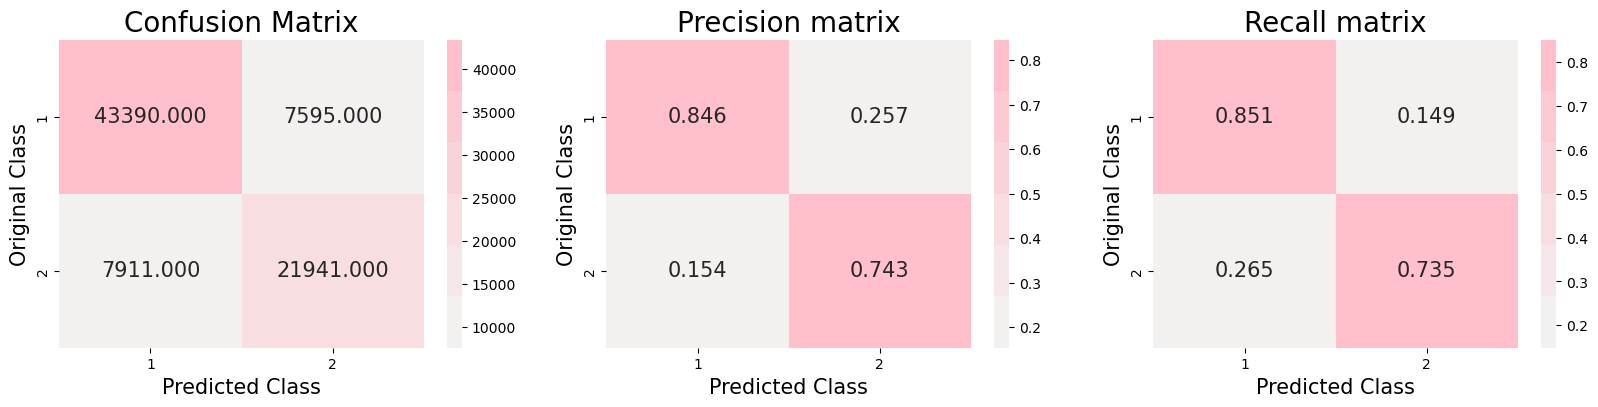

In [67]:
print("Performance Calculation in progress..........")
prediction_evaluation(xgb_reg_model,"XGBoost",X_train, y_train, X_test, y_test)

Performance Calculation in progress..........

--------------- XGBoost Calibrated Performance ---------------
XGBoost Calibrated --> Train --> Log-Loss = 0.2922
XGBoost Calibrated --> Train --> ROC-AUC Score = 0.9486
XGBoost Calibrated --> Test --> Log-Loss = 0.3717
XGBoost Calibrated --> Test --> ROC-AUC Score = 0.9081


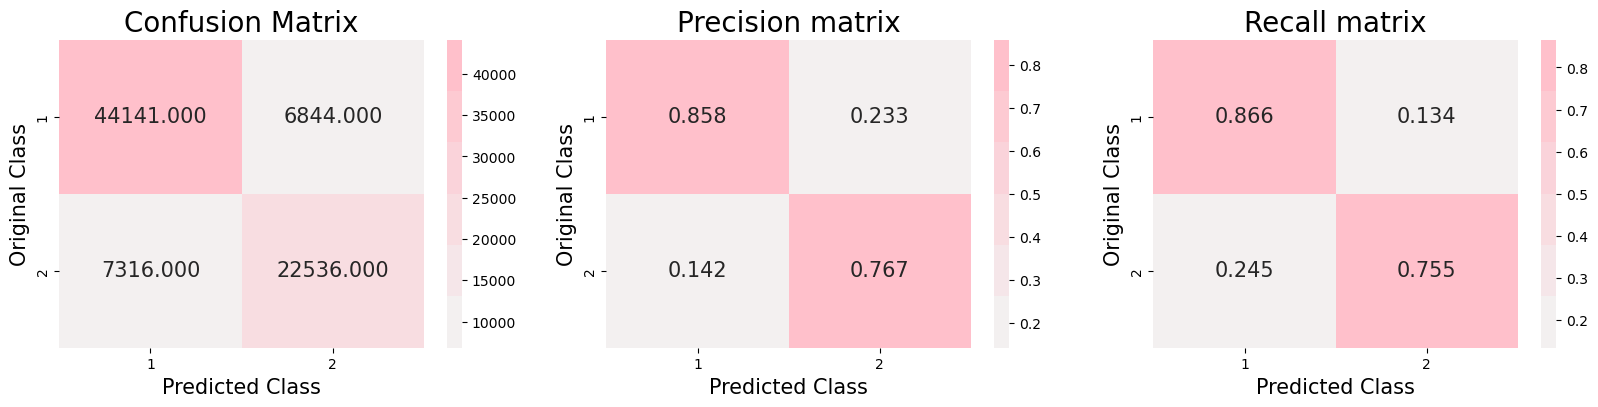

In [50]:
print("Performance Calculation in progress..........")
prediction_evaluation(sig_clf_xgb,"XGBoost Calibrated",X_train, y_train, X_test, y_test)

In [48]:
pickle.dump(file=open("XGBoost_Calibrated_new.pkl","wb"),obj= sig_clf_xgb)

In [25]:
import os 
from IPython.display import FileLink
os.chdir(r'/kaggle/working')
%cd /kaggle/working
FileLink('transformed_df.parquet')

/kaggle/working


/kaggle/working/transformed_df.parquet